In [1]:
# =============================================================================
#  ECUACIÓN DE CALOR 1D CON ALGORITMO GENÉTICO (DEAP) - VERSIÓN CORREGIDA
#  Integrantes: 
#   Luis Pablo López Iracheta 
#   Diego Mares Rodríguez
#   Francisco Marín Castillo
#  Fecha: 28 de oct de 2025
#  
#  du/dt - d2u/dx2 = 0
#  u(0,t) = u(1,t) = 0
#  u(x,0) = 1/5 sin(3πx)
#  0 < t < inf , 0 < x < 1
# =============================================================================

In [2]:
import operator, math, random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, gp, tools, algorithms
import math

In [3]:

# Funciones seguras 
def seguro_div(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1.0
def seguro_sin(x):
    try:
        return math.sin(x)
    except:
        return 0.0
def seguro_cos(x):
    try:
        return math.cos(x)
    except:
        return 0.0

def seguro_exp(x):
    try:
        return math.exp(x) if abs(x) < 10 else (1e6 if x > 0 else -1e6)
    except:
        return 0.0

pset = gp.PrimitiveSet("MAIN", 2) 

pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(operator.neg, 1)
pset.addTerminal(np.pi, name="pi")
#Funciones trigonométricas
pset.addPrimitive(seguro_sin, 1)
pset.addPrimitive(seguro_cos, 1)
pset.addPrimitive(seguro_div, 2)

pset.addEphemeralConstant("rand101", lambda: random.uniform(-3,3))
pset.renameArguments(ARG0='x')  # Variable espacial
pset.renameArguments(ARG1='t')  # Variable temporal

creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # minimo
creator.create("Individuo", gp.PrimitiveTree, fitness=creator.FitnessMin) # Individuo basado en árboles primitivos

d:\anaconda3\envs\ds_venv\Lib\site-packages\deap\gp.py:257: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


Iniciadores

In [4]:
# Configuramos la caja de herramientas
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=3, max_=5) # Profundidad mínima y máxima del árbol inicial
toolbox.register("individual", tools.initIterate, creator.Individuo, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [5]:
# Función objetivo

# Creamo sumplejas mallas donde evaluar las soluciones y sus derivadas
x_vals = np.linspace(0, 1, 25) 
t_vals = np.linspace(0, 1, 25) 
X, T = np.meshgrid(x_vals, t_vals) # Malla 2D

def evaluate_AG(individuo):
    func = toolbox.compile(expr=individuo)

    # Matriz para almacenar soluciones evaluadas
    Nt = len(t_vals)
    Nx = len(x_vals)
    U = np.zeros((Nt, Nx)) # Solución en malla (t,x)
    
    # Evaluar la función
    for i, t in enumerate(t_vals):
        for j, x in enumerate(x_vals):
            try:
                val = func(x, t)
                U[i, j] = val if np.isfinite(val) else 1e6
            except Exception:
                U[i, j] = 1e6
    
    # Derivadas
    dt = t_vals[1] - t_vals[0] # paso en t
    dx = x_vals[1] - x_vals[0] # paso en x
    
    Ux = np.gradient(U, dx, axis=1) # Primera derivada espacial
    Uxx = np.gradient(Ux, dx, axis=1)  # Segunda derivada espacial

    Ut = np.gradient(U, dt, axis=0) # Primera derivada temporal
    
    # Residual de la PDE: d_u/d_t - d_u/d-xx = 0
    residual = Ut - Uxx
    residual_error_cud_medio = np.mean(residual**2)
    
    # Condiciones de frontera, muy penadas para que si o si no se cumplan
    condicion_izquierda = np.mean(U[:, 0]**2) * 1000  
    condicion_derecha = np.mean(U[:, -1]**2) * 1000

    # Condición inicial - EL COMPONENTE MÁS IMPORTANTE
    U0 = U[0, :]
    condicion_inicial = (1.0/5.0) * np.sin(3*np.pi*x_vals)
    condicion_inicial_error_cud_medio = np.mean((U0 - condicion_inicial)**2) * 5000  
    
    # Penalización por soluciones constantes, 
    std_x = np.std(U, axis=1)
    media_estandar = np.mean(std_x)
    constancia_penalizacion = 500 / (media_estandar + 1e-6) if media_estandar < 0.01 else 0

    # Recompensa por estructura correcta
    arbol_generado = str(individuo)
    structure_bonus = 0
    if 'sin' in arbol_generado and 'pi' in arbol_generado:
        structure_bonus -= 10  # Recompensa grande
    
    fitness = (
        residual_error_cud_medio * 5.0 +
        condicion_inicial_error_cud_medio +
        condicion_izquierda + condicion_derecha +
        constancia_penalizacion +
        structure_bonus
    )

    # retorna tupla (porque DEAP espera tuplas)
    return (fitness,)


In [6]:
toolbox.register("evaluate", evaluate_AG) # Evaluador de individuos en la población
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=7)

# Limitar la altura de los individuos
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))




In [7]:
poblacion = toolbox.population(n=300)
hof = tools.HallOfFame(5)  # guardamos los 5 mejores individuos

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)

# Generaciones
generaciones = 200
p_cruza = 0.7
p_muta = 0.3


pop, log = algorithms.eaSimple(poblacion, toolbox, p_cruza, p_muta, generaciones, stats=stats, halloffame=hof)





C:\Users\LUIS PC\AppData\Local\Temp\ipykernel_4688\2910118322.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return left / right
C:\Users\LUIS PC\AppData\Local\Temp\ipykernel_4688\2910118322.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return left / right
<string>:1: RuntimeWarning: invalid value encountered in scalar multiply
<string>:1: RuntimeWarning: invalid value encountered in scalar subtract


gen	nevals	min    
0  	300   	161.216
1  	237   	89.2725
2  	247   	88.2813


<string>:1: RuntimeWarning: invalid value encountered in scalar add


3  	228   	82.462 
4  	253   	82.462 
5  	238   	81.2016
6  	227   	81.2016
7  	240   	78.3192
8  	227   	78.3192
9  	238   	78.3192
10 	246   	78.2016
11 	238   	78.2825
12 	223   	78.3192
13 	240   	77.6912
14 	244   	77.6912
15 	236   	77.6479
16 	238   	77.6479
17 	235   	77.5123
18 	243   	77.3529
19 	239   	76.113 
20 	243   	74.6682
21 	238   	74.6682
22 	241   	73.1047
23 	235   	73.1047
24 	248   	72.1614
25 	243   	71.5627
26 	214   	71.5627
27 	226   	70.7563
28 	238   	71.5627
29 	253   	68.0419
30 	234   	60.1488
31 	225   	60.1488
32 	222   	60.1488
33 	244   	55.7067
34 	234   	55.7067
35 	231   	55.7067
36 	250   	55.7067
37 	228   	55.7067
38 	247   	55.518 
39 	243   	55.518 
40 	233   	54.3668
41 	243   	54.3668
42 	210   	54.3668
43 	246   	54.3668
44 	236   	54.2021
45 	240   	54.2021
46 	240   	54.2021
47 	233   	54.2021
48 	234   	54.2021
49 	239   	54.2021
50 	223   	54.2021
51 	254   	53.6761
52 	236   	52.7785
53 	235   	52.7785
54 	252   	52.3132
55 	221   	5

In [8]:
print("Mejor individuo:", hof[0])
print(f"longitud: {len(hof[0])}, altura: {hof[0].height}")

Mejor individuo: mul(seguro_div(sub(seguro_sin(seguro_div(0.501019802269151, seguro_div(0.6212138496009638, seguro_sin(seguro_sin(seguro_sin(mul(1.9075142509023566, t))))))), seguro_sin(sub(seguro_sin(mul(neg(add(pi, x)), sub(seguro_div(seguro_cos(0.501019802269151), mul(0.6212138496009638, -0.23537307143627206)), seguro_div(seguro_sin(1.9075142509023566), 1.9075142509023566)))), neg(seguro_cos(sub(seguro_sin(t), add(mul(x, t), seguro_sin(x)))))))), pi), neg(seguro_sin(seguro_div(sub(0.9861156540198843, seguro_sin(seguro_sin(seguro_sin(mul(pi, t))))), seguro_div(seguro_div(-2.1040609699469757, seguro_sin(sub(seguro_sin(t), add(mul(x, t), seguro_sin(x))))), seguro_sin(seguro_sin(seguro_sin(mul(pi, t)))))))))
longitud: 75, altura: 10


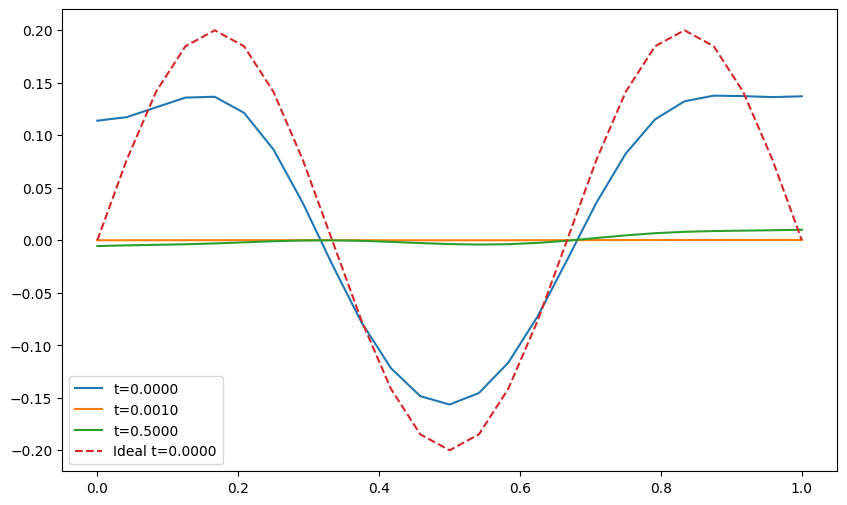

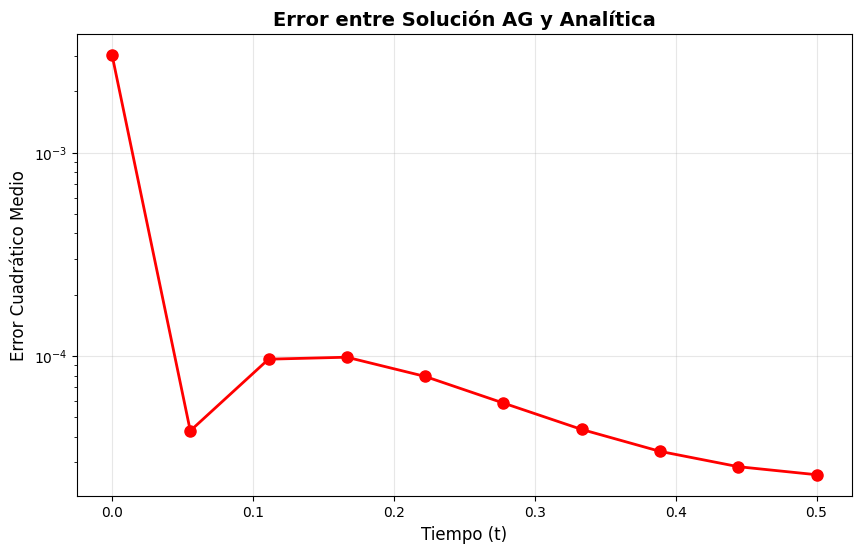

Error cuadrático medio por tiempo:
t = 0.00: MSE = 0.003032
t = 0.06: MSE = 0.000043
t = 0.11: MSE = 0.000096
t = 0.17: MSE = 0.000098
t = 0.22: MSE = 0.000079
t = 0.28: MSE = 0.000059
t = 0.33: MSE = 0.000043
t = 0.39: MSE = 0.000034
t = 0.44: MSE = 0.000028
t = 0.50: MSE = 0.000026


In [ ]:
# Grafica en distintos tiempos
ideal = lambda x, t: (1/5)*np.sin(3*np.pi*x)
best = toolbox.compile(expr=hof[0])
plt.figure(figsize=(10, 6))
for t_plot in [0.0, 0.01, 0.5]:
    U_plot = np.array([best(x, t_plot) for x in x_vals])
    plt.plot(x_vals, U_plot, label=f't={t_plot:.4f}')
# Grfica original ideal
for t_plot in [0.0]:
    U_plot = ideal(x_vals, t_plot)
    plt.plot(x_vals, U_plot, linestyle='dashed', label=f'Ideal t={t_plot:.4f}')

plt.legend()
plt.show()
# Graficar en distintos tiempos con mejoras visuales
ideal = lambda x, t: (1/5)*np.sin(3*np.pi*x)*np.exp(-(3*np.pi)**2 * t)
best = toolbox.compile(expr=hof[0])

times = np.linspace(0, 0.5, 10)


#Error cuadrático medio por tiempo
mse_values = []
for t_plot in times:
    ecuacion_ag = np.array([best(x, t_plot) for x in x_vals])
    ecuacion_analitica = ideal(x_vals, t_plot)
    mse = np.mean((ecuacion_ag - ecuacion_analitica)**2)
    mse_values.append(mse)

# Gráfico de error
plt.figure(figsize=(10, 6))
plt.plot(times, mse_values, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Tiempo (t)', fontsize=12)
plt.ylabel('Error Cuadrático Medio', fontsize=12)
plt.title('Error entre Solución AG y Analítica', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Escala logarítmica para mejor visualización
plt.show()

print("Error cuadrático medio por tiempo:")
for t, mse in zip(times, mse_values):
    print(f"t = {t:.2f}: MSE = {mse:.6f}")

In [10]:
# ****************Segunda opción**********************
poblacion = toolbox.population(n=200)
hof1 = tools.HallOfFame(5)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)

generaciones = 300
p_cruza = 0.7
p_muta = 0.3

mu = 100        # número de individuos seleccionados para reproducirse
lambda_ = 300   # número de descendientes generados por generación
pop, log = algorithms.eaMuPlusLambda(poblacion, toolbox, mu=mu, lambda_=lambda_, cxpb=p_cruza, mutpb=p_muta, ngen=generaciones, stats=stats, halloffame=hof1, verbose=True)
print("Mejor individuo:", hof1[0])
print(f"longitud: {len(hof1[0])}, altura: {hof1[0].height}")


C:\Users\LUIS PC\AppData\Local\Temp\ipykernel_4688\2910118322.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return left / right
C:\Users\LUIS PC\AppData\Local\Temp\ipykernel_4688\2910118322.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return left / right


gen	nevals	min    
0  	200   	114.551
1  	300   	114.551
2  	300   	89.0192
3  	300   	88.3699
4  	300   	86.6305
5  	300   	86.6305
6  	300   	86.6305
7  	300   	82.8087
8  	300   	81.1426
9  	300   	79.3756
10 	300   	72.5157
11 	300   	72.5157
12 	300   	69.4103
13 	300   	65.2165
14 	300   	65.2165
15 	300   	64.4005
16 	300   	62.235 
17 	300   	61.2159
18 	300   	61.1761
19 	300   	61.1761
20 	300   	60.4375
21 	300   	59.0692
22 	300   	59.0692
23 	300   	58.1207
24 	300   	58.1207
25 	300   	58.1207
26 	300   	53.3311
27 	300   	53.3311
28 	300   	52.9113
29 	300   	52.9113
30 	300   	51.1797
31 	300   	50.463 
32 	300   	44.8248
33 	300   	44.8248
34 	300   	44.8248
35 	300   	44.1968
36 	300   	43.7825
37 	300   	39.6265
38 	300   	39.0211
39 	300   	39.0211
40 	300   	38.7984
41 	300   	36.5493
42 	300   	36.5493
43 	300   	36.5493
44 	300   	35.4571
45 	300   	33.4637
46 	300   	32.6515
47 	300   	31.3737
48 	300   	31.3737
49 	300   	30.7503
50 	300   	30.7503
51 	300   	3

C:\Users\LUIS PC\AppData\Local\Temp\ipykernel_4688\2910118322.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return left / right


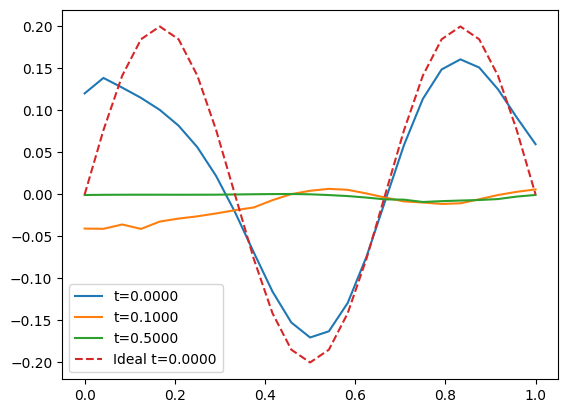

In [11]:
# Grafica en distintos tiempos´
ideal = lambda x, t: (1/5)*np.sin(3*np.pi*x)
best = toolbox.compile(expr=hof1[0])
for t_plot in [0.0, 0.1, 0.5]:
    U_plot = np.array([best(x, t_plot) for x in x_vals])
    plt.plot(x_vals, U_plot, label=f't={t_plot:.4f}')
# Grfica original ideal
for t_plot in [0.0]:
    U_plot = ideal(x_vals, t_plot)
    plt.plot(x_vals, U_plot, linestyle='dashed', label=f'Ideal t={t_plot:.4f}')

plt.legend()
plt.show()